In [84]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/IFT6390/Kaggle/Kaggle1"
os.chdir(path)

import numpy as np
import pandas as pd
from pandas import Series
from scipy.sparse import csr_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preprocessing**

In [85]:
data = pd.read_csv('train.csv') 

# check missing values
# print(data.isnull().sum(axis=0))

data = data.drop('S.No', axis = 1) 
# print(data.duplicated()) check duplicate
data = data.drop_duplicates() #deduplicate

features = ['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS',	'TREFHT',	'Z1000', 'Z200', 'ZBOT']
label = 'LABELS'
data_features = data[features]
data_label = data[label]

#month
month = data['time'].tolist()
for i in range(len(month)):
  month[i] = (month[i] % 10000) // 100
data_features.insert(data_features.shape[1], 'month', month)

#day
day = data['time'].tolist()
for i in range(len(day)):
  day[i] = day[i] % 100
data_features.insert(data_features.shape[1], 'day', day)

#standardization: Normalize train set to mean 0 and standard deviation 1 feature-wise.
mu = data_features.mean()
sigma  = data_features.std()
data_features = (data_features - mu)/sigma

# insert a column of 1s for the bias
data_features.insert(data_features.shape[1], 'BIAS', 1)
data_features.head()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,month,day,BIAS
0,-0.908686,-0.655686,-1.446629,-0.572219,1.037355,-0.713554,1.695781,-1.001604,1.394119,1.392846,1.962688,-0.686451,-0.168176,-0.662828,-0.849857,1.434832,-0.396766,-0.922959,0.136821,-1.272931,1
1,1.216774,0.193733,0.984026,1.298239,2.045043,1.076641,2.149791,1.041804,-1.377296,-1.383923,1.432447,1.332695,-0.193809,1.115359,1.439154,-1.493233,1.273084,1.402851,0.964361,-1.055355,1
2,1.216774,0.171380,-1.787944,-0.298059,-1.361854,-0.243334,-1.104079,-1.697052,0.591978,0.589156,-0.437588,-1.299803,-0.193809,0.432000,-0.840439,0.569268,-1.383491,-1.076930,-1.932029,1.664350,1
3,0.764985,-0.394900,1.395829,0.080610,-0.318709,0.940007,-0.334766,1.110756,-1.338133,-1.344684,0.632722,0.852439,0.183366,0.885178,0.783078,-1.463771,0.655926,0.844398,0.550591,-1.055355,1
4,-0.898418,-0.678039,-0.885710,-1.014248,-1.162562,-1.228055,-0.851582,-0.656311,1.808368,1.807895,-1.123181,-0.200704,-0.169139,-0.611811,-0.409376,1.916569,-0.204134,-0.446988,0.550591,-1.055355,1


In [86]:
test = pd.read_csv('test.csv')
features = ['lat', 'lon','TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS',	'TREFHT',	'Z1000', 'Z200', 'ZBOT']
test_features = test[features]

#month
month = test['time'].tolist()
for i in range(len(month)):
  month[i] = (month[i] % 10000) // 100
test_features.insert(test_features.shape[1], 'month', month)

#day
day = test['time'].tolist()
for i in range(len(day)):
  day[i] = day[i] % 100
test_features.insert(test_features.shape[1], 'day', day)


mu = test_features.mean()
sigma  = test_features.std()
test_features = (test_features - mu)/sigma
test_features.insert(test_features.shape[1], 'BIAS', 1)
test_features.head()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,month,day,BIAS
0,-1.229333,2.042784,-0.983297,-0.193739,-0.123017,-0.825821,-0.358298,-1.410598,2.021822,2.022854,-0.431612,-1.498500,-0.106353,-1.929845,-1.795646,2.010704,-1.765335,-1.731259,0.848069,1.30439,1
1,-1.229333,2.050397,-1.042802,-0.202247,-0.031383,-0.928823,-0.172188,-1.482267,2.033150,2.034209,-0.465811,-1.481222,-0.204784,-1.930019,-1.828771,2.017855,-1.765385,-1.777682,0.848069,1.30439,1
2,-1.229333,2.058010,-1.118994,-0.211497,0.042045,-0.988242,0.047758,-1.525559,2.051553,2.052655,-0.567847,-1.472340,-0.223318,-1.930019,-1.882917,2.031197,-1.755198,-1.838255,0.848069,1.30439,1
3,-1.229333,2.065623,-1.154444,-0.211198,0.134985,-0.978184,0.269036,-1.565374,2.055933,2.057046,-0.671754,-1.449615,-0.272138,-1.914115,-1.934666,2.030726,-1.747432,-1.896030,0.848069,1.30439,1
4,-1.229333,2.073235,-1.180665,-0.201475,0.295448,-0.934087,0.464976,-1.616486,2.045002,2.046088,-0.717009,-1.405900,-0.271125,-1.907302,-1.941000,2.018313,-1.743070,-1.910669,0.848069,1.30439,1


# **Random Forest**

In [105]:
#Train
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
X_train, X_test, y_train, y_test = train_test_split(data_features, data_label, test_size=0.3, random_state=101)
#X_train = data_features
#y_train = data_label
model = RandomForestClassifier(n_estimators=140,max_features='auto', random_state=101)
model.fit(X_train,y_train)

#Predict
from sklearn.metrics import accuracy_score
preds = model.predict(X_test)
accuracy_score(y_test,preds)

0.7814723767628412

0 [0.8572188896249268]
25 [0.8572188896249268, 0.8859503875221254]
50 [0.8572188896249268, 0.8859503875221254, 0.8864169504802796]
75 [0.8572188896249268, 0.8859503875221254, 0.8864169504802796, 0.8865724893731803]
100 [0.8572188896249268, 0.8859503875221254, 0.8864169504802796, 0.8865724893731803, 0.8870043876555911]
125 [0.8572188896249268, 0.8859503875221254, 0.8864169504802796, 0.8865724893731803, 0.8870043876555911, 0.8870907613431236]
150 [0.8572188896249268, 0.8859503875221254, 0.8864169504802796, 0.8865724893731803, 0.8870043876555911, 0.8870907613431236, 0.8870389448902387]
175 [0.8572188896249268, 0.8859503875221254, 0.8864169504802796, 0.8865724893731803, 0.8870043876555911, 0.8870907613431236, 0.8870389448902387, 0.8870562339532245]
0.8870907613431236 125


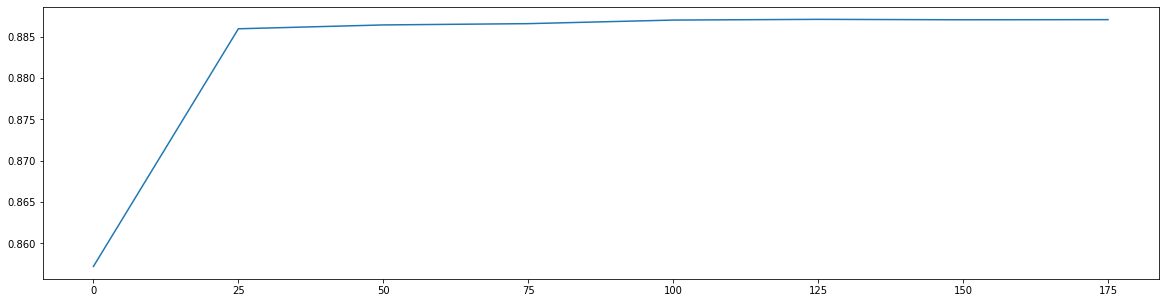

In [88]:
#determine n_estimator
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
scorel = []
for i in range(0,200,25): 
  rfc = RandomForestClassifier(n_estimators=i+1,max_features='auto', random_state=101)
  score = cross_val_score(rfc,over_samples_X,over_samples_y,cv=10).mean()
  scorel.append(score)
  print(i,scorel)
print(max(scorel),(scorel.index(max(scorel))*25)+0)
plt.figure(figsize=[20,5])
plt.plot(range(0,200,25),scorel)
plt.show()

100 [0.8870043876555911]
110 [0.8870043876555911, 0.8870043816866413]
120 [0.8870043876555911, 0.8870043816866413, 0.887073490186987]
130 [0.8870043876555911, 0.8870043816866413, 0.887073490186987, 0.8871425807804831]
140 [0.8870043876555911, 0.8870043816866413, 0.887073490186987, 0.8871425807804831, 0.887142583764958]
150 [0.8870043876555911, 0.8870043816866413, 0.887073490186987, 0.8871425807804831, 0.887142583764958, 0.8870389448902387]
0.887142583764958 140


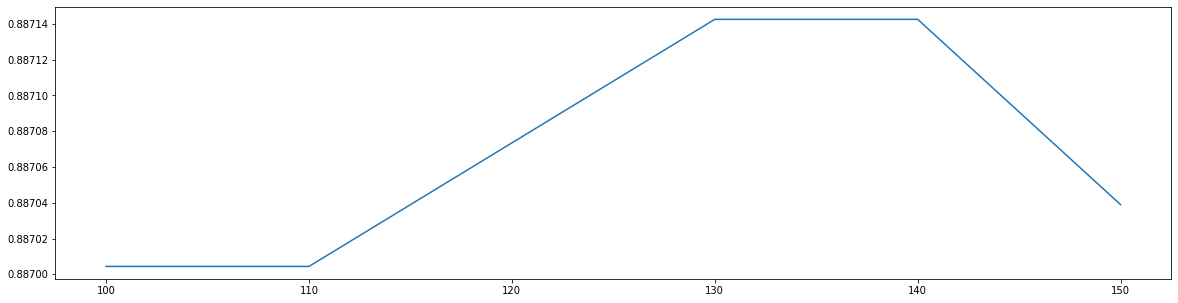

In [104]:
scorel = []
for i in range(100,151,10): 
  rfc = RandomForestClassifier(n_estimators=i+1,max_features='auto', random_state=101)
  score = cross_val_score(rfc,over_samples_X,over_samples_y,cv=10).mean()
  scorel.append(score)
  print(i,scorel)
print(max(scorel),(scorel.index(max(scorel))*10)+100)
plt.figure(figsize=[20,5])
plt.plot(range(100,151,10),scorel)
plt.show()

# **Balancing the training data set**

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
over_samples = SMOTE(random_state = 101)
over_samples_X, over_samples_y = over_samples.fit_sample(data_features, data_label)
print('Counter({0:', data['LABELS'][data['LABELS'] == 0].count(), ',' + '1:', data['LABELS'][data['LABELS'] == 1].count(),',' + '1:', data['LABELS'][data['LABELS'] == 2].count(),'}]')
print(Counter(over_samples_y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 19295 ,1: 1218 ,1: 5250 }]
Counter({0: 19295, 1: 19295, 2: 19295})


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(over_samples_X, over_samples_y, test_size=0.3, random_state=101)
k_fold = KFold(n_splits = 10, shuffle = True, random_state = 0)

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
#X_train = data_features
#y_train = data_label
model = RandomForestClassifier(n_estimators=140,max_features='auto', random_state=101)
model.fit(X_train,y_train)

#Predict
from sklearn.metrics import accuracy_score
#preds = model.predict(X_train)
#accuracy_score(y_train,preds)
preds = model.predict(X_test)
print('Confusion matrix:\n', confusion_matrix(y_test, preds))
print('Accuracy score:', accuracy_score(y_test, preds))
#cv = (cross_val_score(model,X_train,y_train,cv = k_fold,n_jobs=1,scoring='accuracy').mean())
#accuracy_score(y_test,preds)
#print('Cross val score:', cv)

Confusion matrix:
 [[4989  134  685]
 [ 153  193   25]
 [ 673   19  858]]
Accuracy score: 0.7814723767628412


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      5801
           1       0.95      0.97      0.96      5789
           2       0.86      0.86      0.86      5776

    accuracy                           0.89     17366
   macro avg       0.89      0.89      0.89     17366
weighted avg       0.89      0.89      0.89     17366



In [ ]:
#test_features = sc_X.transform(test_features)
pre = model.predict(test_features)
res=pd.DataFrame(pre, columns = ['LABELS'])
res.to_csv("result_RF_balance.csv") 

# **Relation between data and features**

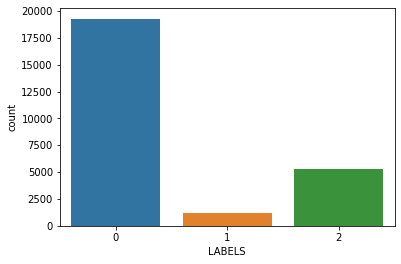

In [ ]:
import seaborn as sns
data.LABELS.value_counts()
srs.countplot(x = 'LABELS', data = data)

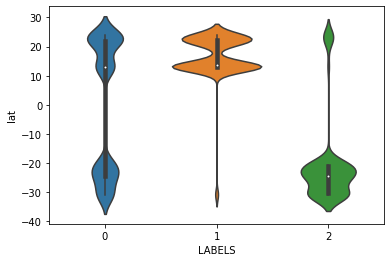

In [ ]:
#lat
data[data.LABELS == 0].lat.mean()
data[data.LABELS == 1].lat.mean()
data[data.LABELS == 2].lat.mean()
sns.violinplot(x = 'LABELS', y = 'lat', data = data)

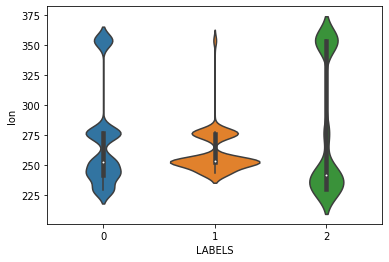

In [ ]:
#lon
data[data.LABELS == 0].lon.mean()
data[data.LABELS == 1].lon.mean()
data[data.LABELS == 2].lon.mean()
sns.violinplot(x = 'LABELS', y = 'lon', data = data)

AxesSubplot(0.125,0.125;0.775x0.755)


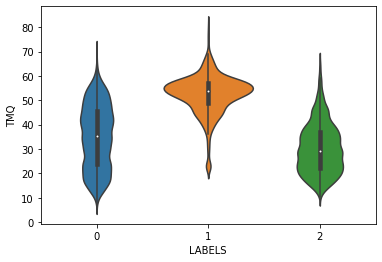

In [ ]:
#TMQ
data[data.LABELS == 0].TMQ.mean()
data[data.LABELS == 1].TMQ.mean()
data[data.LABELS == 2].TMQ.mean()
print(sns.violinplot(x = 'LABELS', y = 'TMQ', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


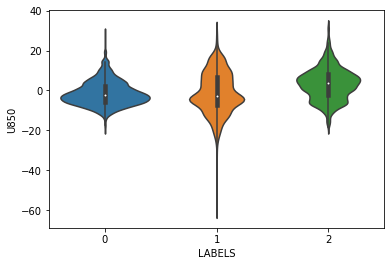

In [ ]:
#U850
data[data.LABELS == 0].U850.mean()
data[data.LABELS == 1].U850.mean()
data[data.LABELS == 2].U850.mean()
print(sns.violinplot(x = 'LABELS', y = 'U850', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


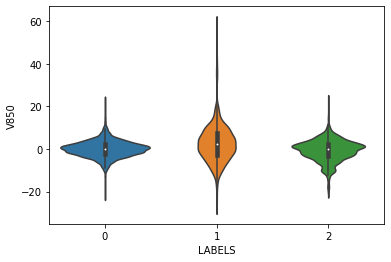

In [ ]:
#V850
data[data.LABELS == 0].V850.mean()
data[data.LABELS == 1].V850.mean()
data[data.LABELS == 2].V850.mean()
print(sns.violinplot(x = 'LABELS', y = 'V850', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


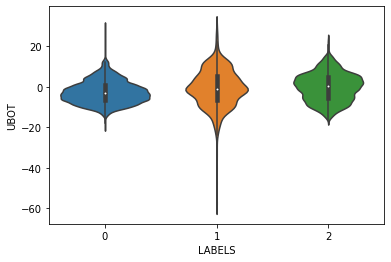

In [ ]:
#UBOT
data[data.LABELS == 0].UBOT.mean()
data[data.LABELS == 1].UBOT.mean()
data[data.LABELS == 2].UBOT.mean()
print(sns.violinplot(x = 'LABELS', y = 'UBOT', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


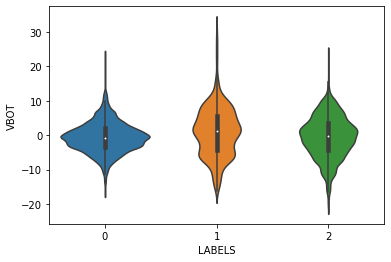

In [ ]:
#VBOT
data[data.LABELS == 0].VBOT.mean()
data[data.LABELS == 1].VBOT.mean()
data[data.LABELS == 2].VBOT.mean()
print(sns.violinplot(x = 'LABELS', y = 'VBOT', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


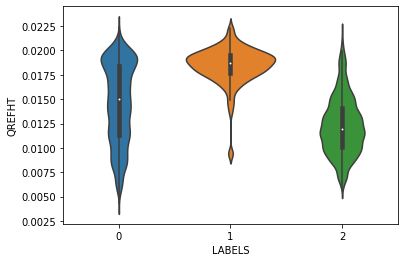

In [ ]:
#QREFHT
data[data.LABELS == 0].QREFHT.mean()
data[data.LABELS == 1].QREFHT.mean()
data[data.LABELS == 2].QREFHT.mean()
print(sns.violinplot(x = 'LABELS', y = 'QREFHT', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


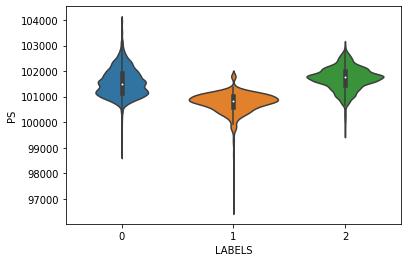

In [ ]:
#PS
data[data.LABELS == 0].PS.mean()
data[data.LABELS == 1].PS.mean()
data[data.LABELS == 2].PS.mean()
print(sns.violinplot(x = 'LABELS', y = 'PS', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


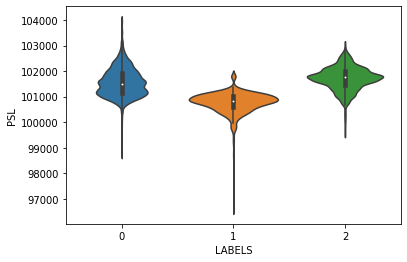

In [ ]:
#PSL
data[data.LABELS == 0].PSL.mean()
data[data.LABELS == 1].PSL.mean()
data[data.LABELS == 2].PSL.mean()
print(sns.violinplot(x = 'LABELS', y = 'PSL', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


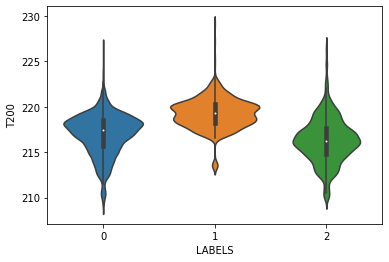

In [ ]:
#T200
data[data.LABELS == 0].T200.mean()
data[data.LABELS == 1].T200.mean()
data[data.LABELS == 2].T200.mean()
print(sns.violinplot(x = 'LABELS', y = 'T200', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


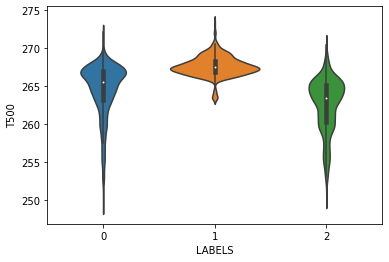

In [ ]:
#T500
data[data.LABELS == 0].T500.mean()
data[data.LABELS == 1].T500.mean()
data[data.LABELS == 2].T500.mean()
print(sns.violinplot(x = 'LABELS', y = 'T500', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


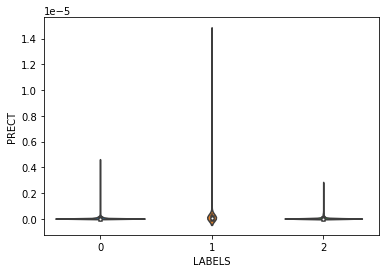

In [ ]:
#PRECT
data[data.LABELS == 0].PRECT.mean()
data[data.LABELS == 1].PRECT.mean()
data[data.LABELS == 2].PRECT.mean()
print(sns.violinplot(x = 'LABELS', y = 'PRECT', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


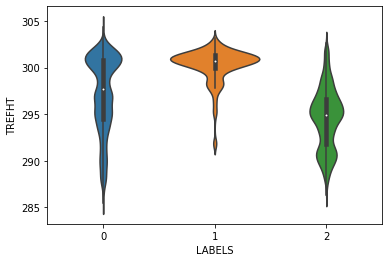

In [ ]:
#TREFHT
data[data.LABELS == 0].TREFHT.mean()
data[data.LABELS == 1].TREFHT.mean()
data[data.LABELS == 2].TREFHT.mean()
print(sns.violinplot(x = 'LABELS', y = 'TREFHT', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


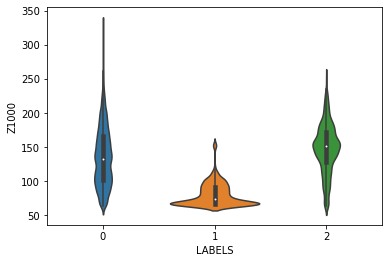

In [ ]:
#Z1000
data[data.LABELS == 0].Z1000.mean()
data[data.LABELS == 1].Z1000.mean()
data[data.LABELS == 2].Z1000.mean()
print(sns.violinplot(x = 'LABELS', y = 'Z1000', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


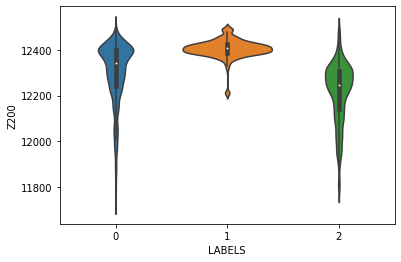

In [ ]:
#Z200
data[data.LABELS == 0].Z200.mean()
data[data.LABELS == 1].Z200.mean()
data[data.LABELS == 2].Z200.mean()
print(sns.violinplot(x = 'LABELS', y = 'Z200', data = data))

AxesSubplot(0.125,0.125;0.775x0.755)


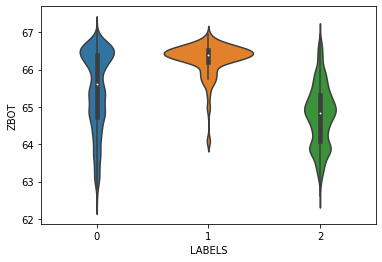

In [ ]:
#ZBOT
data[data.LABELS == 0].ZBOT.mean()
data[data.LABELS == 1].ZBOT.mean()
data[data.LABELS == 2].ZBOT.mean()
print(sns.violinplot(x = 'LABELS', y = 'ZBOT', data = data))

# **Naive Bayes**

In [98]:
# GaussianNB - Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(data_features, data_label, test_size=0.3) 

gaussianNB=GaussianNB()
gaussianNB.fit(X_train,y_train) 

dataset_predict_y=gaussianNB.predict(X_test)
correct_predicts=(dataset_predict_y==y_test).sum()
accuracy=100*correct_predicts/y_test.shape[0]
print('GaussianNB, correct prediction num: {}, accuracy: {:.2f}%'
      .format(correct_predicts,accuracy))

GaussianNB, correct prediction num: 4004, accuracy: 51.80%


In [99]:
#BernouliNB - Naive Bayes
from sklearn.naive_bayes import BernoulliNB
bernoulliNB=BernoulliNB()
bernoulliNB.fit(X_train,y_train) 

dataset_predict_y_bern=bernoulliNB.predict(X_test)
correct_predicts_bern=(dataset_predict_y_bern==y_test).sum()
accuracy=100*correct_predicts/y_test.shape[0]
print('BernoulliNB, correct prediction num: {}, accuracy: {:.2f}%'
      .format(correct_predicts_bern,accuracy))

BernoulliNB, correct prediction num: 3284, accuracy: 51.80%


# **SVM**

In [107]:
from sklearn import datasets
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(data_features, data_label, test_size=0.3, random_state=101) 

clf_linear = svm.SVC(decision_function_shape="ovo", kernel="linear")
clf_rbf = svm.SVC(decision_function_shape="ovo", kernel="rbf")
clf_linear.fit(X_train, y_train)
clf_rbf.fit(X_train, y_train)
#clf_linear.fit(datas_features, datas_label)
#clf_rbf.fit(datas_features, datas_label)

y_test_pre_linear = clf_linear.predict(X_test)
y_test_pre_rbf = clf_rbf.predict(X_test)
#y_test_pre_linear = clf_linear.predict(datas_features)
#y_test_pre_rbf = clf_rbf.predict(datas_features)

acc_linear = sum(y_test_pre_linear==y_test)/y_test.shape[0]
print('linear kernel: The accuracy is', acc_linear) 
acc_rbf = sum(y_test_pre_rbf==y_test)/y_test.shape[0]
print('rbf kernel: The accuracy is', acc_rbf)

linear kernel: The accuracy is 0.7616768016561004
rbf kernel: The accuracy is 0.8228748867900116


In [103]:
clf_rbf = svm.SVC(decision_function_shape="ovo", kernel="rbf")
clf_rbf.fit(data_features, data_label)
pre_rbf = clf_rbf.predict(test_features)
res=pd.DataFrame(pre, columns = ['LABELS'])
#res.to_csv("result_SVM_rbf.csv") 